In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import time

# Function to fetch data with retry mechanism using Ticker()
def fetch_data(ticker_symbol, period='30d', retries=3):
    for attempt in range(retries):
        try:
            ticker = yf.Ticker(ticker_symbol)
            data = ticker.history(period=period)
            if not data.empty:
                return data
            else:
                print(f"No data returned for {ticker_symbol}. Retrying...")
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
        time.sleep(2)  # Wait 2 seconds before retrying
    print(f"Failed to fetch data for {ticker_symbol} after {retries} attempts.")
    return None

# Fetch historical data for TSLA over the past 30 days
ticker = 'TSLA'
data = fetch_data(ticker, period='30d')



Minimum percentage change from Wednesday to Friday for TSLA: -6.31%
Maximum percentage change from Wednesday to Friday for TSLA: 5.74%


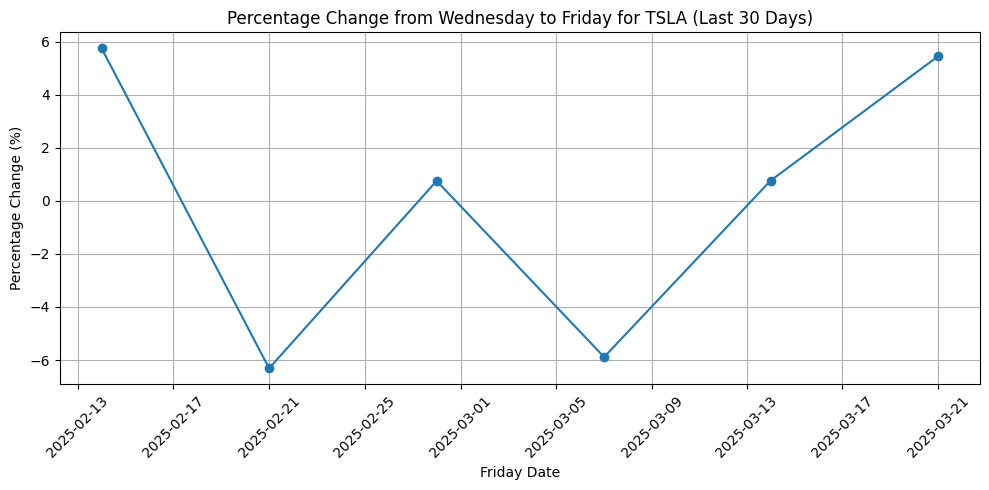

In [4]:
# Check if data was fetched successfully
if data is None or data.empty:
    print(f"Cannot proceed: No price data available for {ticker}.")
else:
    # Add day of week column (0 = Monday, 2 = Wednesday, 4 = Friday, 6 = Sunday)
    data['DayOfWeek'] = data.index.dayofweek

    # Filter for Wednesdays and Fridays
    wf_data = data[data['DayOfWeek'].isin([2, 4])].copy()

    # Add year and week columns
    wf_data['Year'] = wf_data.index.year
    wf_data['Week'] = wf_data.index.isocalendar().week

    # Group by year and week
    grouped = wf_data.groupby(['Year', 'Week'])

    # Calculate percentage changes for each complete Wednesday-Friday pair
    percentage_changes = []
    friday_dates = []

    for name, group in grouped:
        if len(group) == 2:  # Ensure exactly two days in the group
            group = group.sort_index()  # Sort by date
            if group.iloc[0]['DayOfWeek'] == 2 and group.iloc[1]['DayOfWeek'] == 4:
                wed_close = group.iloc[0]['Close']  # Using 'Close' instead of 'Adj Close'
                fri_close = group.iloc[1]['Close']
                pct_change = ((fri_close - wed_close) / wed_close) * 100
                percentage_changes.append(pct_change)
                friday_dates.append(group.iloc[1].name)  # Store the Friday date

    # Find min and max percentage changes and display results
    if percentage_changes:
        min_pct_change = min(percentage_changes)
        max_pct_change = max(percentage_changes)
        print(f"Minimum percentage change from Wednesday to Friday for {ticker}: {min_pct_change:.2f}%")
        print(f"Maximum percentage change from Wednesday to Friday for {ticker}: {max_pct_change:.2f}%")
        
        # Plot the percentage changes
        plt.figure(figsize=(10, 5))
        plt.plot(friday_dates, percentage_changes, marker='o', linestyle='-')
        plt.title(f'Percentage Change from Wednesday to Friday for {ticker} (Last 30 Days)')
        plt.xlabel('Friday Date')
        plt.ylabel('Percentage Change (%)')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No complete Wednesday-Friday pairs found in the last 30 days.")